## Preparación

In [4]:
%%capture
#@title Instalamos gym
!pip install swig
!pip install "gymnasium[box2d]"
!pip install numpy
!pip install matplotlib
!pip install tqdm
#!pip install "gymnasium[toy-text]"
!pip install Box2D
!pip install pygame


In [5]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import Box2D
import random

In [6]:
#@title Importamos el lago helado
name = 'Taxi-v3'

# Creamos el entorno Taxi-v3
env = gym.make(name, render_mode="rgb_array")


In [7]:
# Política Greedy a partir de los valores Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    frames = []
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=100)  # start in top-left, = 0
    img = env.render()
    frames.append(img)
    actions = ""
    
    while not done:
        # Obtener los valores Q para el estado actual y encontrar la mejor acción
        q_values = Q[state]  # Q es un defaultdict, esto retorna el array de valores para el estado
        action = np.argmax(q_values)
        
        # Registrar la acción
        actions += f"{action}, "
        pi_star[state, action] = action
        
        # Ejecutar la acción en el ambiente
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        done = terminated or truncated
    
    return pi_star, actions, frames

In [8]:
def plot_training_results(rewards):
    # Calculamos la media móvil para suavizar la gráfica
    window_size = 50
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg, label='Recompensa promedio (media móvil)')
    plt.plot(rewards, alpha=0.2, label='Recompensa por episodio')
    plt.title('Entrenamiento del agente en Taxi-v3')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa total')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_learning_analysis(list_stats, episode_sizes):
    # Creamos una figura con 3 subplots
    plt.figure(figsize=(12, 9))
    
    # 1. Proporción de recompensas
    plt.subplot(3, 1, 1)
    indices = list(range(len(list_stats)))
    plt.plot(indices, list_stats)
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    
    # 2. Tamaño de los episodios
    plt.subplot(3, 1, 2)
    indices = list(range(len(episode_sizes)))
    plt.plot(indices, episode_sizes)
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(indices[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Tamaño de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Número de pasos')
    plt.grid(True)
    plt.legend()
    
    # 3. Longitud del episodio en función del tiempo f(t) = len(episodiot)
    plt.subplot(3, 1, 3)
    cumulative_steps = np.cumsum(episode_sizes)
    plt.plot(cumulative_steps, episode_sizes, label='Longitud del episodio')
    # Media móvil para ver la tendencia
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(cumulative_steps[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Longitud del episodio vs Tiempo total')
    plt.xlabel('Tiempo total (pasos acumulados)')
    plt.ylabel('Longitud del episodio')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
from moviepy import ImageSequenceClip  # pip install moviepy
def create_gif(frames: list, filename, fps=5):
   """
   Creates a GIF animation from a list of RGBA NumPy arrays.
   Args:
       frames: A list of RGBA NumPy arrays representing the animation frames.
       filename: The output filename for the GIF animation.
       fps: The frames per second of the animation (default: 10).
   """
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_videofile(filename, fps=fps)

## Temporales

### Q-Learning

In [323]:
import numpy as np
from collections import defaultdict
import random

class QLearningAgent:
    def __init__(self, env, eps=1, decay = True, gamma=0.99, alpha=0.2):
        """Initialize agent.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.decay = decay
        
        # Initialize Q-table based on action space, not observation space
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def epsilon_greedy(self, state):
        """Epsilon-greedy action selection."""
        if random.random() > self.eps:  # select greedy action with probability 1-epsilon
            return np.argmax(self.Q[state])
        else:  # select random action with probability epsilon
            return random.randint(0, self.env.action_space.n - 1)
    
    def get_action(self, state, episode):
        if self.decay:
            self.eps = min(1.0, 1000.0 / (episode + 1))
        """Select an action given the current state."""
        return self.epsilon_greedy(state)
    
    def update(self, state, action, reward, next_state, done):
        """Update the agent's knowledge using the most recently sampled tuple.
        
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]
        
        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            Qsa_next = np.max(self.Q[next_state])
        
        # Q-learning update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

In [324]:
agent = QLearningAgent(env)
    
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = 100000 / 10

# Bucle de entrenamiento
for episode in tqdm(range(100000)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.get_action(obs, episode)  # Cambiado de get_action a select_action para mantener consistencia
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Actualizar el agente
        agent.update(obs, action, reward, next_obs, terminated)  # Usando el método step definido anteriormente
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1
        
    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats/(episode+1))
    
    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)
    
    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/episode}, epsilon: {agent.eps}")


 11%|█         | 10620/100000 [00:07<00:23, 3776.65it/s]

success: -103.4995, epsilon: 0.0999900009999


 20%|██        | 20412/100000 [00:10<00:21, 3741.55it/s]

success: -49.65605, epsilon: 0.04999750012499375


 31%|███       | 30762/100000 [00:13<00:18, 3691.37it/s]

success: -31.166266666666665, epsilon: 0.033332222259258026


 40%|████      | 40491/100000 [00:15<00:14, 4195.88it/s]

success: -21.74785, epsilon: 0.02499937501562461


 51%|█████     | 50881/100000 [00:17<00:11, 4232.19it/s]

success: -16.0349, epsilon: 0.01999960000799984


 61%|██████    | 60686/100000 [00:20<00:09, 3951.63it/s]

success: -12.1852, epsilon: 0.01666638889351844


 71%|███████   | 70763/100000 [00:23<00:06, 4257.40it/s]

success: -9.420214285714286, epsilon: 0.014285510206997042


 81%|████████  | 80510/100000 [00:25<00:04, 4232.67it/s]

success: -7.3278875, epsilon: 0.0124998437519531


 91%|█████████ | 90620/100000 [00:28<00:02, 4040.50it/s]

success: -5.695922222222222, epsilon: 0.011110987655692715


100%|██████████| 100000/100000 [00:30<00:00, 3268.26it/s]


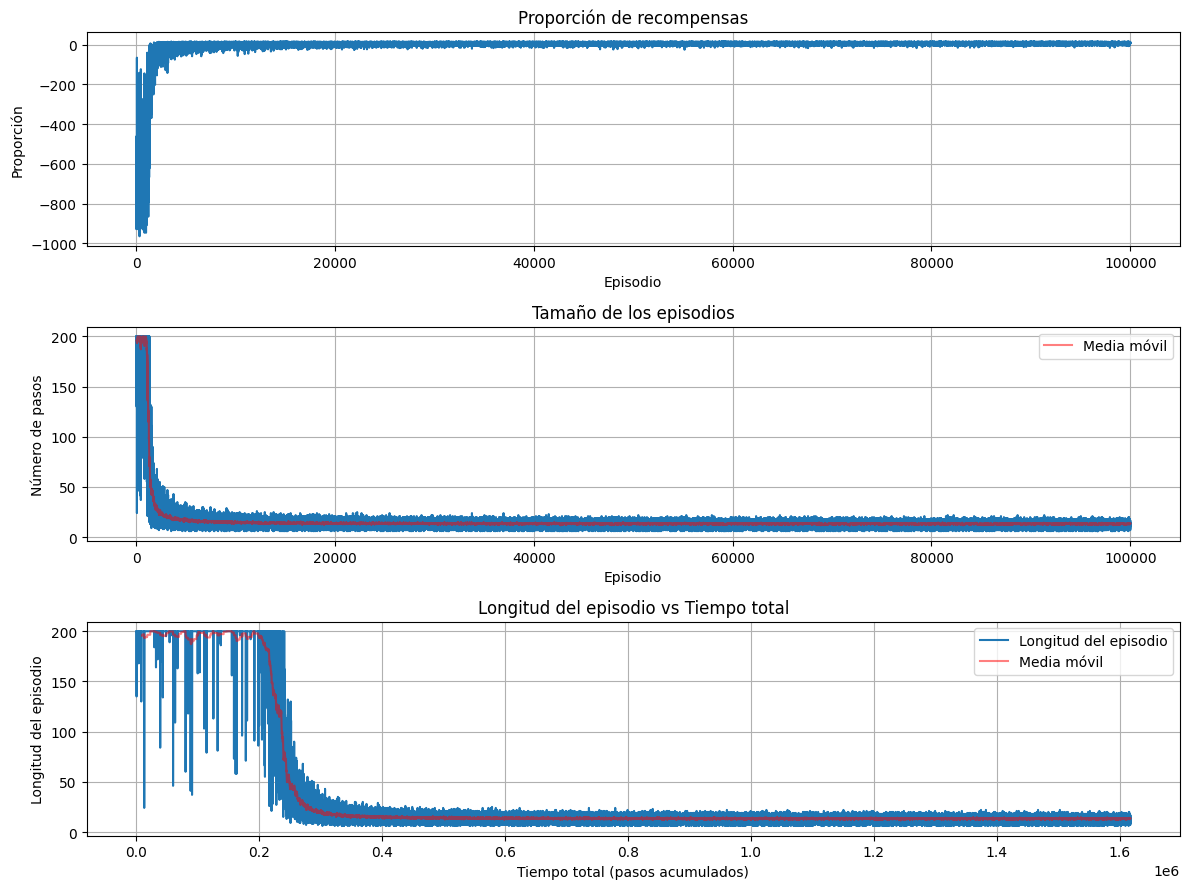

In [325]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)

In [326]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 2, 0, 0, 4, 1, 1, 1, 2, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [327]:
# Example usage
create_gif(frames, "Q-Learning.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video Q-Learning.mp4.
MoviePy - Writing video Q-Learning.mp4



MoviePy - Done !
MoviePy - video ready Q-Learning.mp4


### Sarsa


In [328]:
import numpy as np
from collections import defaultdict
import random

class SarsaAgent:
    def __init__(self, env, eps=0.4, decay = True, gamma=0.99, alpha=0.2):
        """Initialize agent.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.decay = decay
        
        # Initialize Q-table based on action space, not observation space
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def epsilon_greedy(self, state):
        """Epsilon-greedy action selection."""
        if random.random() > self.eps:  # select greedy action with probability 1-epsilon
            return np.argmax(self.Q[state])
        else:  # select random action with probability epsilon
            return random.randint(0, self.env.action_space.n - 1)
    
    def get_action(self, state, episode):
        if self.decay:
            self.eps = min(1.0, 1000.0 / (episode + 1))
        """Select an action given the current state."""
        return self.epsilon_greedy(state)
    
    def update(self, state, action, reward, next_state, done):
        """Update the agent's knowledge using the most recently sampled tuple.
        
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]
        
        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            next_action = self.epsilon_greedy(next_state)
            Qsa_next = self.Q[next_state][next_action]
        
        # Sarsa update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

In [329]:
agent = SarsaAgent(env)
    
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = 100000 / 10

# Bucle de entrenamiento
for episode in tqdm(range(100000)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.get_action(obs, episode)  # Cambiado de get_action a select_action para mantener consistencia
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Actualizar el agente
        agent.update(obs, action, reward, next_obs, terminated)  # Usando el método step definido anteriormente
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1
        
    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats/(episode+1))
    
    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)
    
    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/episode}, epsilon: {agent.eps}")


 11%|█         | 10725/100000 [00:06<00:19, 4473.85it/s]

success: -107.8672, epsilon: 0.0999900009999


 21%|██        | 20579/100000 [00:08<00:16, 4731.06it/s]

success: -51.8668, epsilon: 0.04999750012499375


 31%|███       | 30866/100000 [00:10<00:13, 4997.75it/s]

success: -32.670433333333335, epsilon: 0.033332222259258026


 41%|████      | 40847/100000 [00:12<00:11, 5007.26it/s]

success: -22.904425, epsilon: 0.02499937501562461


 51%|█████     | 50849/100000 [00:14<00:10, 4895.03it/s]

success: -16.97472, epsilon: 0.01999960000799984


 61%|██████    | 60912/100000 [00:16<00:08, 4663.21it/s]

success: -12.978183333333334, epsilon: 0.01666638889351844


 71%|███████   | 70700/100000 [00:18<00:06, 4816.30it/s]

success: -10.116457142857143, epsilon: 0.014285510206997042


 81%|████████  | 80736/100000 [00:20<00:03, 4843.44it/s]

success: -7.9540375, epsilon: 0.0124998437519531


 90%|█████████ | 90482/100000 [00:22<00:01, 4917.27it/s]

success: -6.260088888888889, epsilon: 0.011110987655692715


100%|██████████| 100000/100000 [00:24<00:00, 4028.54it/s]


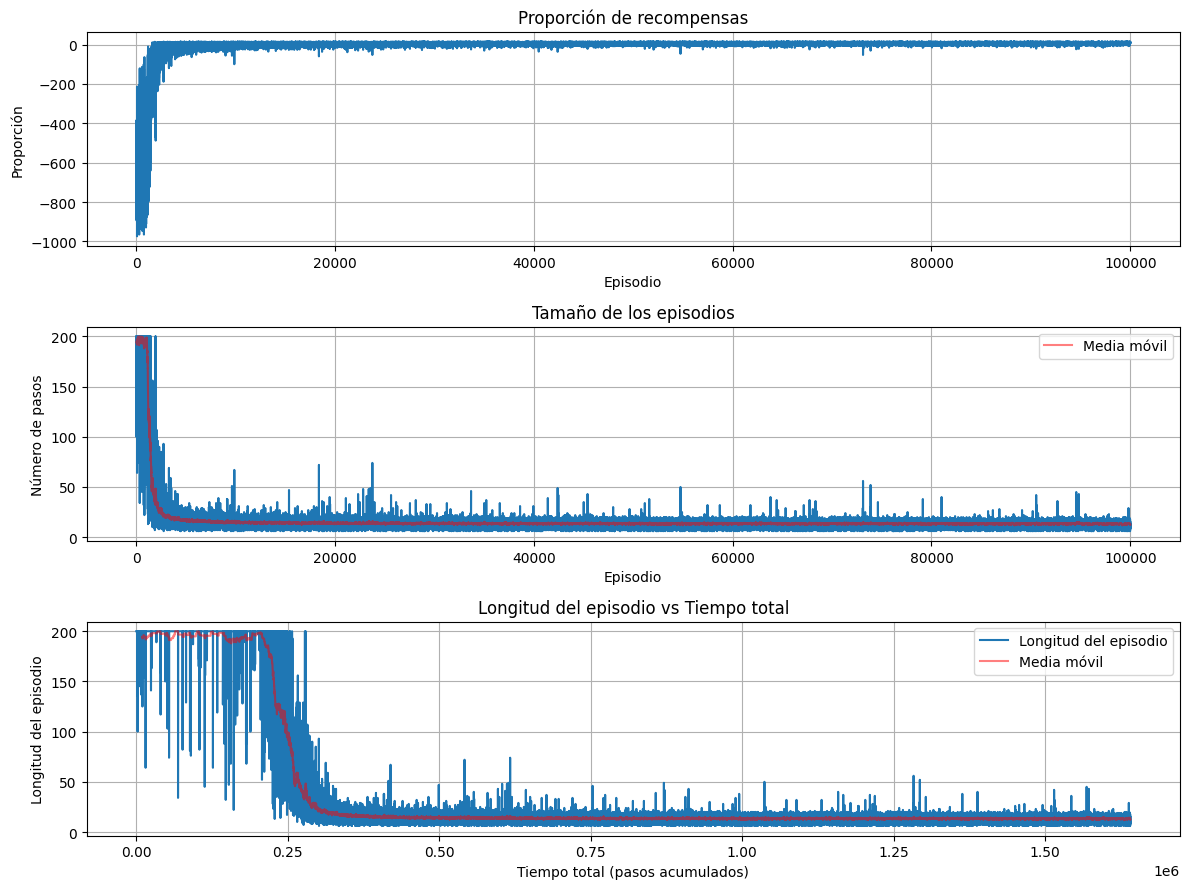

In [330]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)

In [331]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 2, 0, 0, 4, 2, 1, 1, 1, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [332]:
# Example usage
create_gif(frames, "Sarsa.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video Sarsa.mp4.
MoviePy - Writing video Sarsa.mp4



MoviePy - Done !
MoviePy - video ready Sarsa.mp4


## Monte Carlo


### Off-policy

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

# Hiperparámetros
NUM_EPISODES = 100000
GAMMA = 0.99  # Factor de descuento
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.001

# Clase MonteCarloOffPolicyAgent
class MonteCarloOffPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.C = np.zeros((self.env.observation_space.n, self.env.action_space.n))  # Suma de pesos de Importance Sampling

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo Off-Policy
    def update(self, episode):
        G = 0  # Retorno total
        W = 1  # Peso de Importance Sampling

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            self.C[state, action] += W
            self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])

            # Si la acción no es la óptima según la política objetivo, terminar el episodio
            if action != np.argmax(self.Q[state]):
                break

            W = W * 1.0 / (self.epsilon / self.env.action_space.n + (1 - self.epsilon) * (action == np.argmax(self.Q[state])))

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [339]:
# Inicializar el agente
agent = MonteCarloOffPolicyAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Guardar datos del episodio
        episode_data.append((obs, action, reward))
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

# Cerrar el entorno
env.close()

 10%|█         | 10123/100000 [00:11<00:52, 1700.16it/s]

Éxito promedio: -149.8493, Épsilon: 0.01


 20%|██        | 20238/100000 [00:17<00:40, 1959.72it/s]

Éxito promedio: -86.5756, Épsilon: 0.01


 30%|███       | 30469/100000 [00:21<00:19, 3622.22it/s]

Éxito promedio: -58.0646, Épsilon: 0.01


 41%|████      | 40595/100000 [00:23<00:15, 3738.55it/s]

Éxito promedio: -41.91645, Épsilon: 0.01


 50%|█████     | 50340/100000 [00:26<00:13, 3799.87it/s]

Éxito promedio: -32.17984, Épsilon: 0.01


 61%|██████    | 60584/100000 [00:29<00:10, 3664.62it/s]

Éxito promedio: -25.705883333333333, Épsilon: 0.01


 71%|███████   | 70630/100000 [00:31<00:07, 3746.92it/s]

Éxito promedio: -21.06212857142857, Épsilon: 0.01


 80%|████████  | 80368/100000 [00:34<00:05, 3642.54it/s]

Éxito promedio: -17.57365, Épsilon: 0.01


 91%|█████████ | 90622/100000 [00:37<00:02, 3759.87it/s]

Éxito promedio: -14.865677777777778, Épsilon: 0.01


100%|██████████| 100000/100000 [00:39<00:00, 2508.00it/s]


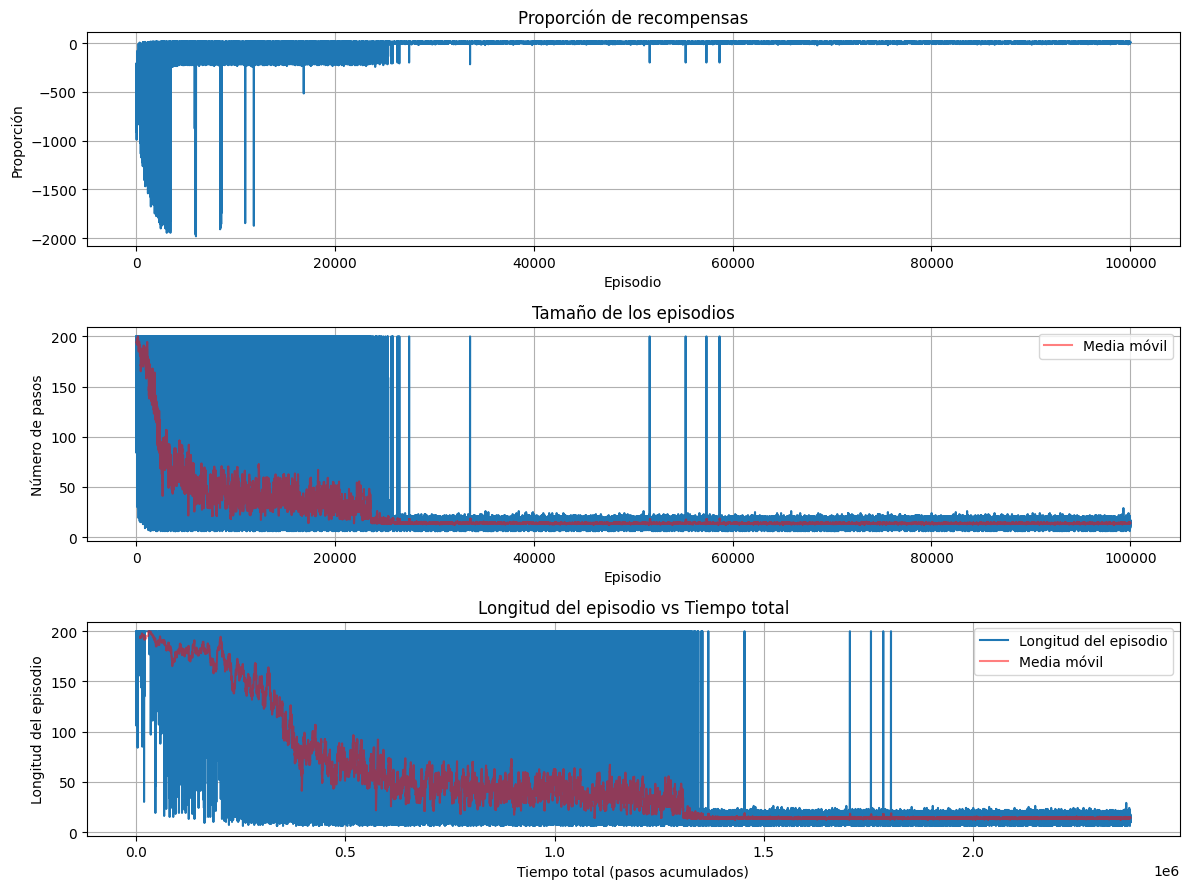

In [340]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)

In [341]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 1, 2, 0, 2, 2, 0, 0, 4, 1, 1, 1, 1, 2, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [342]:
# Example usage
create_gif(frames, "MCOffPolicy.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video MCOffPolicy.mp4.
MoviePy - Writing video MCOffPolicy.mp4



MoviePy - Done !
MoviePy - video ready MCOffPolicy.mp4


### On-policy

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

# Hiperparámetros
NUM_EPISODES = 100000
GAMMA = 0.99  # Factor de descuento
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.001

# Clase MonteCarloOffPolicyAgent
class MonteCarloOnPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.returns = {}  # Diccionario para almacenar los retornos de cada par (estado, acción)

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo On-Policy
    def update(self, episode):
        states, actions, rewards = zip(*episode)
        G = 0  # Retorno total

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # Si el par (state, action) no ha sido visitado en este episodio
            if (state, action) not in [(x[0], x[1]) for x in episode[:t]]:
                if (state, action) not in self.returns:
                    self.returns[(state, action)] = []
                self.returns[(state, action)].append(G)
                self.Q[state, action] = np.mean(self.returns[(state, action)])

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [346]:
# Inicializar el agente
agent = MonteCarloOnPolicyAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Guardar datos del episodio
        episode_data.append((obs, action, reward))
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 10%|█         | 10122/100000 [00:15<02:06, 708.26it/s]

Éxito promedio: -76.6386, Épsilon: 0.01


 20%|██        | 20034/100000 [00:34<03:11, 418.41it/s]

Éxito promedio: -52.65875, Épsilon: 0.01


 30%|███       | 30026/100000 [01:03<03:44, 312.06it/s]

Éxito promedio: -42.321466666666666, Épsilon: 0.01


 40%|████      | 40024/100000 [01:43<05:29, 181.87it/s]

Éxito promedio: -36.402625, Épsilon: 0.01


 50%|█████     | 50036/100000 [02:33<04:45, 174.93it/s]

Éxito promedio: -31.80598, Épsilon: 0.01


 60%|██████    | 60008/100000 [03:43<05:09, 129.34it/s]

Éxito promedio: -26.528266666666667, Épsilon: 0.01


 70%|███████   | 70012/100000 [05:02<04:38, 107.53it/s]

Éxito promedio: -22.542571428571428, Épsilon: 0.01


 80%|████████  | 80014/100000 [06:46<03:36, 92.44it/s] 

Éxito promedio: -19.3217625, Épsilon: 0.01


 90%|█████████ | 90013/100000 [08:32<01:52, 88.68it/s] 

Éxito promedio: -16.67551111111111, Épsilon: 0.01


100%|██████████| 100000/100000 [10:48<00:00, 154.14it/s]


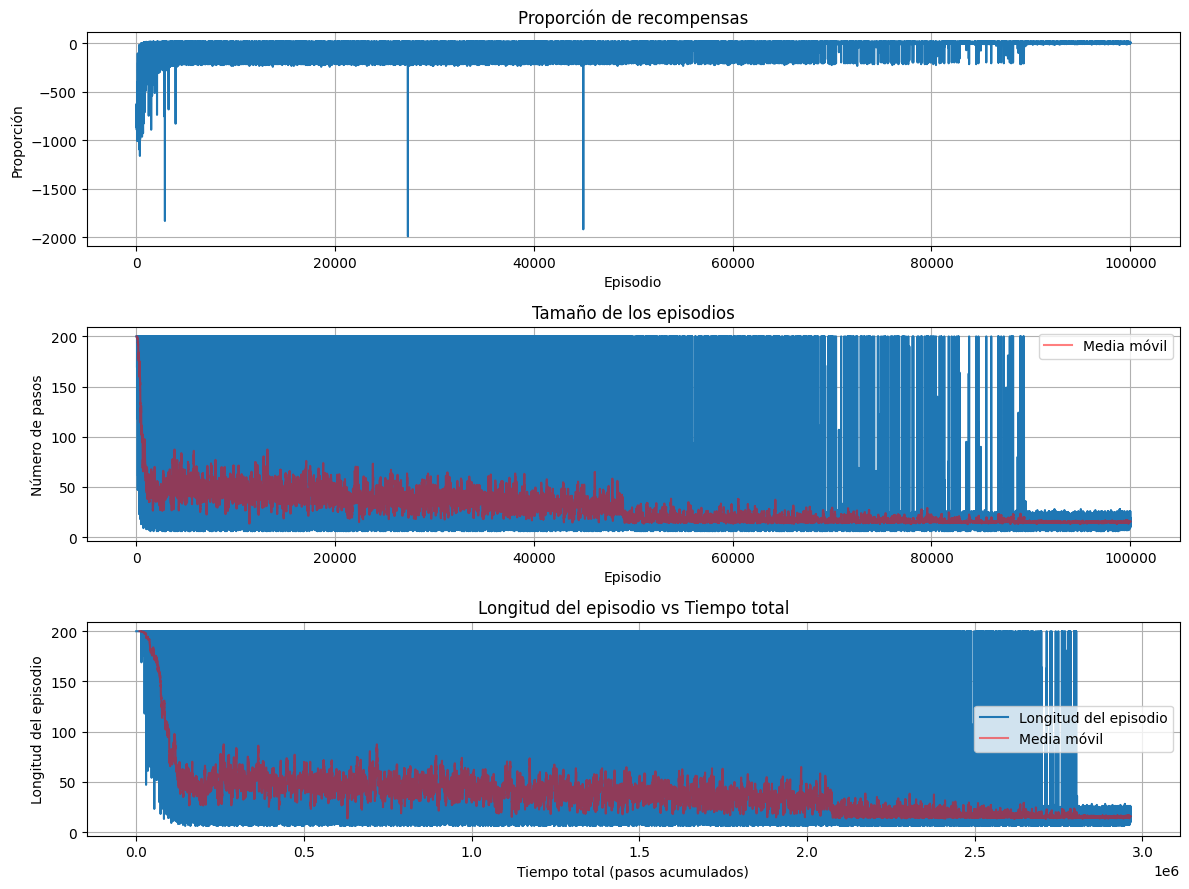

In [347]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)

In [348]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 1, 1, 2, 0, 0, 2, 2, 0, 0, 4, 2, 1, 1, 3, 1, 2, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [349]:
# Example usage
create_gif(frames, "MCOnPolicy.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video MCOnPolicy.mp4.
MoviePy - Writing video MCOnPolicy.mp4



MoviePy - Done !
MoviePy - video ready MCOnPolicy.mp4


## Control con Aproximaciones

### Sarsa Semi-gradiente

In [10]:
# Hiperparámetros
NUM_EPISODES = 100000
GAMMA = 0.99  # Factor de descuento
ALPHA = 0.01  # Tasa de aprendizaje
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.01

# Clase SarsaSemiGradientAgent
class SarsaSemiGradientAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializar los pesos de la función de valor Q(s, a)
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.weights = np.zeros((self.num_states, self.num_actions))  # Pesos para la aproximación lineal

    # Política ε-greedy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q(state))  # Explotación: mejor acción según Q

    # Aproximación lineal de Q(s, a)
    def Q(self, state):
        return self.weights[state]  # Q(s, a) = weights[s, a]

    # Actualizar los pesos usando SARSA Semi-Gradiente
    def update(self, state, action, reward, next_state, next_action, done):
        if done:
            target = reward  # Si el episodio termina, el valor objetivo es la recompensa inmediata
        else:
            target = reward + self.gamma * self.Q(next_state)[next_action]  # Valor objetivo para SARSA

        # Calcular el error temporal
        td_error = target - self.Q(state)[action]

        # Actualizar los pesos usando el gradiente
        self.weights[state, action] += self.alpha * td_error

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [11]:
# Inicializar el agente
agent = SarsaSemiGradientAgent(
    env=env,
    gamma=GAMMA,
    alpha=ALPHA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0

    # Seleccionar la primera acción
    action = agent.get_action(obs)

    while not done:
        # Tomar la acción y observar el siguiente estado y recompensa
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Seleccionar la siguiente acción
        next_action = agent.get_action(next_obs)
        
        # Actualizar el agente
        agent.update(obs, action, reward, next_obs, next_action, terminated)
        
        # Actualizar estado y métricas
        obs = next_obs
        action = next_action
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 11%|█         | 10612/100000 [00:11<00:25, 3459.53it/s]

Éxito promedio: -87.4002, Épsilon: 0.01


 21%|██        | 20910/100000 [00:13<00:15, 5153.26it/s]

Éxito promedio: -40.8803, Épsilon: 0.01


 31%|███       | 30543/100000 [00:15<00:14, 4820.10it/s]

Éxito promedio: -24.7805, Épsilon: 0.01


 41%|████      | 40949/100000 [00:17<00:10, 5400.39it/s]

Éxito promedio: -16.73195, Épsilon: 0.01


 51%|█████     | 50650/100000 [00:19<00:09, 4943.82it/s]

Éxito promedio: -11.899, Épsilon: 0.01


 61%|██████    | 60620/100000 [00:21<00:07, 5137.55it/s]

Éxito promedio: -8.678866666666666, Épsilon: 0.01


 71%|███████   | 70596/100000 [00:23<00:05, 5020.89it/s]

Éxito promedio: -6.3784, Épsilon: 0.01


 81%|████████  | 80693/100000 [00:25<00:04, 4574.71it/s]

Éxito promedio: -4.642625, Épsilon: 0.01


 91%|█████████ | 90615/100000 [00:27<00:01, 4862.56it/s]

Éxito promedio: -3.2954555555555554, Épsilon: 0.01


100%|██████████| 100000/100000 [00:29<00:00, 3438.30it/s]


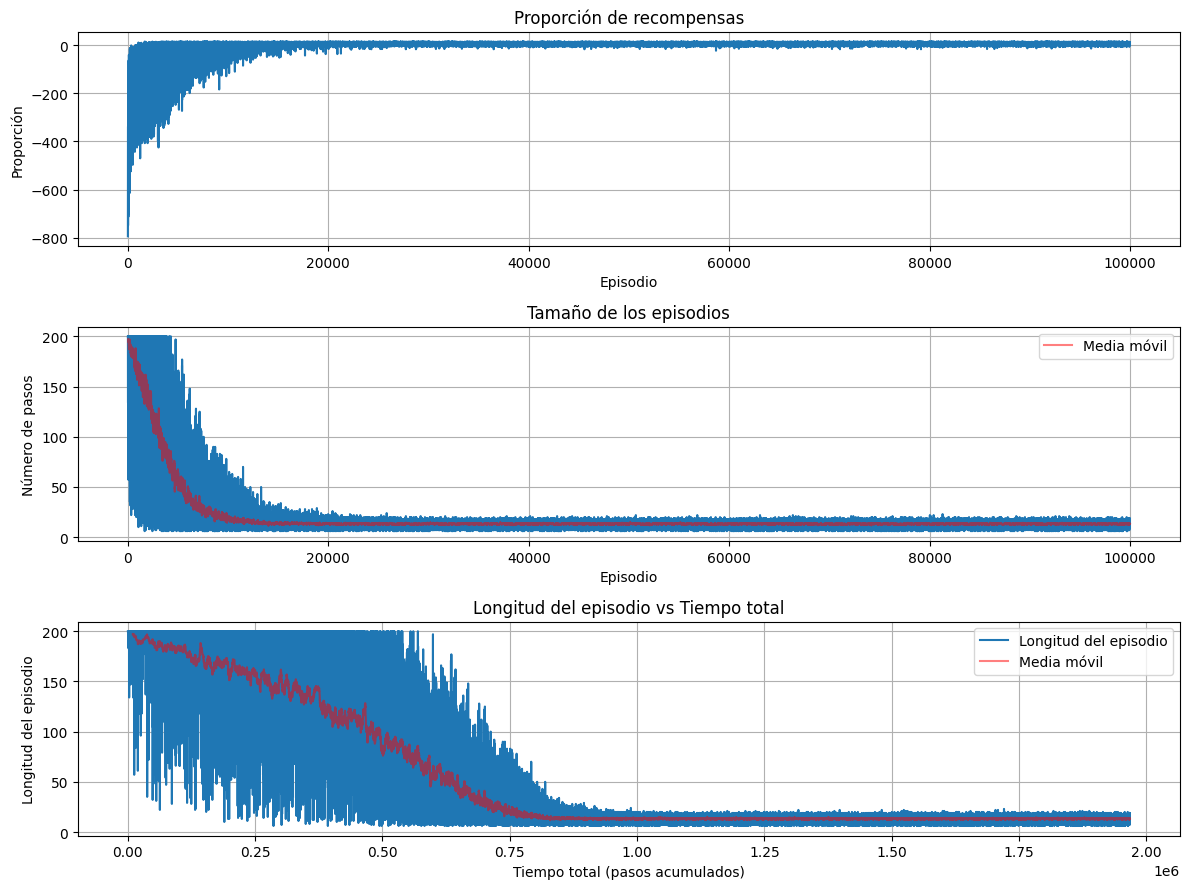

In [12]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)

In [15]:
pi, actions, frames = pi_star_from_Q(env, agent.weights)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 2, 0, 0, 4, 1, 1, 2, 1, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



### Deep Q-Learning

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Hiperparámetros
NUM_EPISODES = 1000
GAMMA = 0.99  # Factor de descuento
ALPHA = 0.001  # Tasa de aprendizaje
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
BATCH_SIZE = 64
BUFFER_SIZE = 10000
TARGET_UPDATE = 10  # Frecuencia de actualización de la red objetivo

# Red Neuronal para aproximar Q(s, a)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [19]:
# Clase DQNAgent
class DQNAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon, buffer_size, batch_size, target_update):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update = target_update

        # Inicializar la red neuronal y la red objetivo
        self.state_size = env.observation_space.n  # Tamaño del espacio de observación (500)
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_size, self.action_size)
        self.target_network = QNetwork(self.state_size, self.action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)

        # Buffer de experiencia
        self.buffer = deque(maxlen=buffer_size)

    # Política ε-greedy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)  # Exploración: acción aleatoria
        else:
            state_tensor = self._to_one_hot(state).unsqueeze(0)  # Convertir el estado a one-hot y añadir dimensión de batch
            q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()  # Explotación: mejor acción según Q

    # Añadir una transición al buffer de experiencia
    def add_experience(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # Actualizar la red neuronal
    def update(self):
        if len(self.buffer) < self.batch_size:
            return  # No hay suficientes experiencias para entrenar

        # Muestrear un batch de experiencias
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convertir a tensores de PyTorch
        states = torch.stack([self._to_one_hot(s) for s in states])  # Forma: (batch_size, state_size)
        actions = torch.LongTensor(actions)  # Forma: (batch_size,)
        rewards = torch.FloatTensor(rewards)  # Forma: (batch_size,)
        next_states = torch.stack([self._to_one_hot(s) for s in next_states])  # Forma: (batch_size, state_size)
        dones = torch.FloatTensor(dones)  # Forma: (batch_size,)

        # Calcular los valores Q actuales
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))  # Forma: (batch_size, 1)

        # Calcular los valores Q objetivo
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]  # Forma: (batch_size,)
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)  # Forma: (batch_size,)

        # Calcular la pérdida y actualizar la red
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

    # Actualizar la red objetivo
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    # Convertir un estado discreto a one-hot encoding
    def _to_one_hot(self, state):
        one_hot = torch.zeros(self.state_size)
        one_hot[state] = 1
        return one_hot

In [20]:
# Inicializar el agente
agent = DQNAgent(
    env=env,
    gamma=GAMMA,
    alpha=ALPHA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    target_update=TARGET_UPDATE
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        # Seleccionar una acción
        action = agent.get_action(obs)
        
        # Tomar la acción y observar el siguiente estado y recompensa
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Añadir la experiencia al buffer
        agent.add_experience(obs, action, reward, next_obs, terminated)
        
        # Actualizar el agente
        agent.update()
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Actualizar la red objetivo cada cierto número de episodios
    if episode % TARGET_UPDATE == 0:
        agent.update_target_network()

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 10%|█         | 101/1000 [00:50<07:20,  2.04it/s]

Éxito promedio: -213.97, Épsilon: 0.01


 20%|██        | 201/1000 [01:41<06:50,  1.95it/s]

Éxito promedio: -209.415, Épsilon: 0.01


 30%|███       | 301/1000 [02:34<05:57,  1.95it/s]

Éxito promedio: -208.19666666666666, Épsilon: 0.01


 40%|████      | 401/1000 [03:27<05:06,  1.95it/s]

Éxito promedio: -207.5425, Épsilon: 0.01


 50%|█████     | 501/1000 [04:20<04:26,  1.87it/s]

Éxito promedio: -207.132, Épsilon: 0.01


 60%|██████    | 601/1000 [05:16<03:24,  1.95it/s]

Éxito promedio: -206.96333333333334, Épsilon: 0.01


 70%|███████   | 701/1000 [06:10<02:46,  1.80it/s]

Éxito promedio: -206.75285714285715, Épsilon: 0.01


 80%|████████  | 801/1000 [07:04<01:46,  1.87it/s]

Éxito promedio: -206.64, Épsilon: 0.01


 90%|█████████ | 901/1000 [07:56<00:49,  1.99it/s]

Éxito promedio: -206.45222222222222, Épsilon: 0.01


100%|██████████| 1000/1000 [08:47<00:00,  1.90it/s]


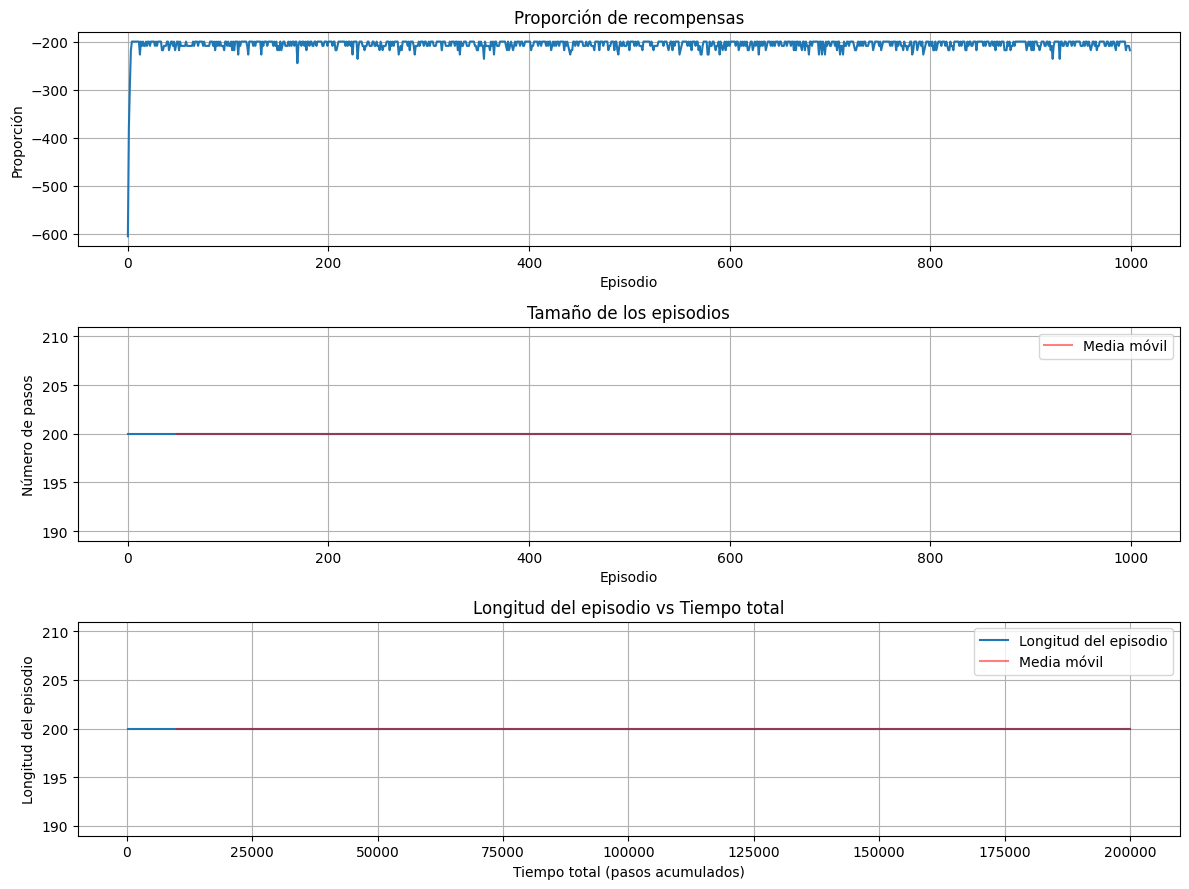

In [21]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)

In [22]:
pi, actions, frames = pi_star_from_Q(env, agent.weights)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

AttributeError: 'DQNAgent' object has no attribute 'weights'